# Exploratory Data Analysis of Scooter Rental Data

This notebook aims to provide insight on how different features influence the total number of scooter users.

Firstly, we want to __understand our target variable__, which in this case is the number of rental scooter users. We will be looking at its distribution before and after any __transformations__ made.

Next, we will examine the influence on the number of users from two main angles:
* How does the number of users change in relation to different time periods, from different Seasons to the Time of Day?
* How do the weather conditions affect the number of users and which factors have the greatest impact?

These methods would provide us insight on what to expect for our __model coefficients__ later on, which can be used as sanity checks for our models. 

#### Importing Libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import pickle
import time

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # higher resolution plots

from mlp import visualisation as viz
import plotly.express as px

import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Misc
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')

#### Loading Data

In [3]:
with open('./data/eda_dataset.pickle', 'rb') as f:
    df = pickle.load(f)

### Visualising Our Target Variable : Total Scooter Users

From the diagram, we observe that our target variable is very positively skewed, with the median users being around 1700.  

After taking a logarithmic transformation, the distribution is still negatively skewed but looks much more normally distributed. We will be using the log-transformed variable as the new target as it has a more normal distribution which typically leads to a better model fit.  

In [4]:
# Plotting the ditribution of total users before and after transformation
viz.var_distribution_plots(df, 'total_users', transform=True, transform_type='log')

#### Comparing Total Users Across Different Years
From the diagram, we can see that the company has been successful in achieving growth in user acquisitions with the median and total number of users across all months have increased year on year.

In [4]:
fig = px.box(df, x='month', y='total_users', color='year')

fig.update_layout(height=500, width=1000, title='2011 vs 2012 Total Users Across The Different Months',
                  showlegend=True, paper_bgcolor='rgb(243, 243, 243)', plot_bgcolor='rgb(243, 243, 243)')
fig.show()

### Relationship Between Total Users Across Different Time-Related Variables

We will be examining the different time related variables, starting from the longest time periods such as seasons and to the short time periods such as the different timings within a day.

#### Feature : Season

From the diagram below, we can see that as the seasons get warmer, total users increases. We can notice a large contraction in median number of users in winter as compared to the other seasons. 

The median number of users in winter is 1002, which is more than 2 times smaller than the median users in summer at 2355. 

In [5]:
viz.sorted_categorical_boxplots(df, 'season', 'total_users')

#### Feature : Month

Unsurprisingly, similar to seasons, the hotter months have higher number of users as we have saw in our earlier plots.

In [6]:
viz.sorted_categorical_boxplots(df, 'month', 'total_users')

#### Feature Day of Week

In [7]:
groupby_dayofweek = df.groupby('dayofweek').total_users.median()
groupby_dayofweek = groupby_dayofweek.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                     'Friday', 'Saturday', 'Sunday']).reset_index()

In [8]:
fig = px.bar(groupby_dayofweek, x='dayofweek', y='total_users')

colors = ['crimson',] * 7
colors [5] = 'lightslategray'
colors[6] = 'lightslategray'

fig.update_traces(marker_color=colors,
                  marker_line_width=1.5, opacity=0.8)

fig.update_layout(height=500, width=750, title='Median Number of Users Per Day of Week',
                  paper_bgcolor='rgb(243, 243, 243)', plot_bgcolor='rgb(243, 243, 243)')

fig.show()

From the above diagram, we can see that the weekdays have significantly higher median number of users as compared to the weekends.

It is interesting to note that the median number of users increases as the week goes by from Monday to Friday.

#### Feature : Time of Day 

Next, we examine how the number of users fluctuates within the day itself.

In [9]:
avg_users_season_hourly = pd.DataFrame(df.groupby(["hr","season"],sort=True)["total_users"].median()).reset_index()

fig = px.scatter(avg_users_season_hourly,
                 x='hr', y='total_users', color='season',
                 width=1000)
fig.data[0].update(mode='lines+markers', name='Autumn')
fig.data[1].update(mode='lines+markers', name='Spring')
fig.data[2].update(mode='lines+markers', name='Summer')
fig.data[3].update(mode='lines+markers', name='Winter')

fig.update_layout(height=500, width=1000, title='Median Users At Different Times of Day and Across Seasons',
                  paper_bgcolor='rgb(243, 243, 243)', plot_bgcolor='rgb(243, 243, 243)', yaxis_title='Median Number of Users',
                  xaxis_title='Time of Day', xaxis_dtick=4)

fig.show()

The figure shows that the general usage patterns remain largely the same across the different seasons of the year, with higher usage during the hotter months as we have noted previously.

The two peaks of the figure are unsurprising and correspond to the typical commute hours. However, it is interesting to note that there are more users during the evening rush hour. 

Furthermore, thre is an uptick of users during midday, which suggests that some people are using the scooters to commute to lunch places. Hence, there may be ann opportunity for the company to work with food vendors to provide promotions to users such as accumulating points when scooters are used during lunch hours that can be exchanged for coupons at different restaurants.

#### Comparing Guest and Registered Users

Now that we have a good understanding of the overall usage patterns, we want to take a look at the differences between guest and registered users and identify if they have any differing usage patterns.

In [10]:
avg_guest_users = df.groupby('hr')['guest_users'].median()
avg_registered_users = df.groupby('hr')['registered_users'].median()

trace_1 = go.Scatter(x=avg_guest_users.index, y=avg_guest_users.values,
                     name='Guest Users', mode='lines+markers')

trace_2 = go.Scatter(x=avg_registered_users.index, y=avg_registered_users.values,
                     name='Registered Users', mode='lines+markers')

data = [trace_1, trace_2]

layout = dict(title='Guest vs. Registered Median Users Count At Different Times During the Day', 
              height=500, width=1000, xaxis_title='Time of Day', yaxis_title='Median Number of Users',
              paper_bgcolor='rgb(243, 243, 243)', plot_bgcolor='rgb(243, 243, 243)')

fig = go.Figure(data=data, layout=layout)

fig.show()

We notice significantly different usage patterns between guest users, with guest users having a very low variance in usage across different timings of the day.

The median number of registered users during the commute hours are largely the same for both legs of the journey. However, for guest users, there is a significantly higher number of users towards the evening timings. Therefore, there may be an opportunity to convert more guest users by providing promotions that encourage user to use the scooter more often, such as discounts to users who rent a scooter within 12 hours of the previous ride.  

### Weather Variables

Now that we have a good understanding of how the number of scooter users relate to time variables. We will examine how the weather conditions affect the number of users. 

#### Feature : Weather

In [11]:
groupby_weather = df.groupby('weather').total_users.median().reset_index()

fig = px.bar(groupby_weather, x='weather', y='total_users')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.update_layout(height=400, width=400, title='Influence of Weather Conditions on Users',
                  paper_bgcolor='rgb(243, 243, 243)', plot_bgcolor='rgb(243, 243, 243)')

fig.show()

Unsurprisingly, as the general weather condition deteriorates, the median number of users decreases.

### Correlation Heatmap

In [12]:
# Rearranging our dataset
df_arranged = df.drop(['hr', 'date', 'weather', 'guest_users', 'registered_users', 'log_total_users',
                       'month', 'season', 'dayofweek'], axis=1)
df_arranged['log_total_users'] = df.log_total_users
df = df_arranged
del df_arranged

(9.5, -0.5)

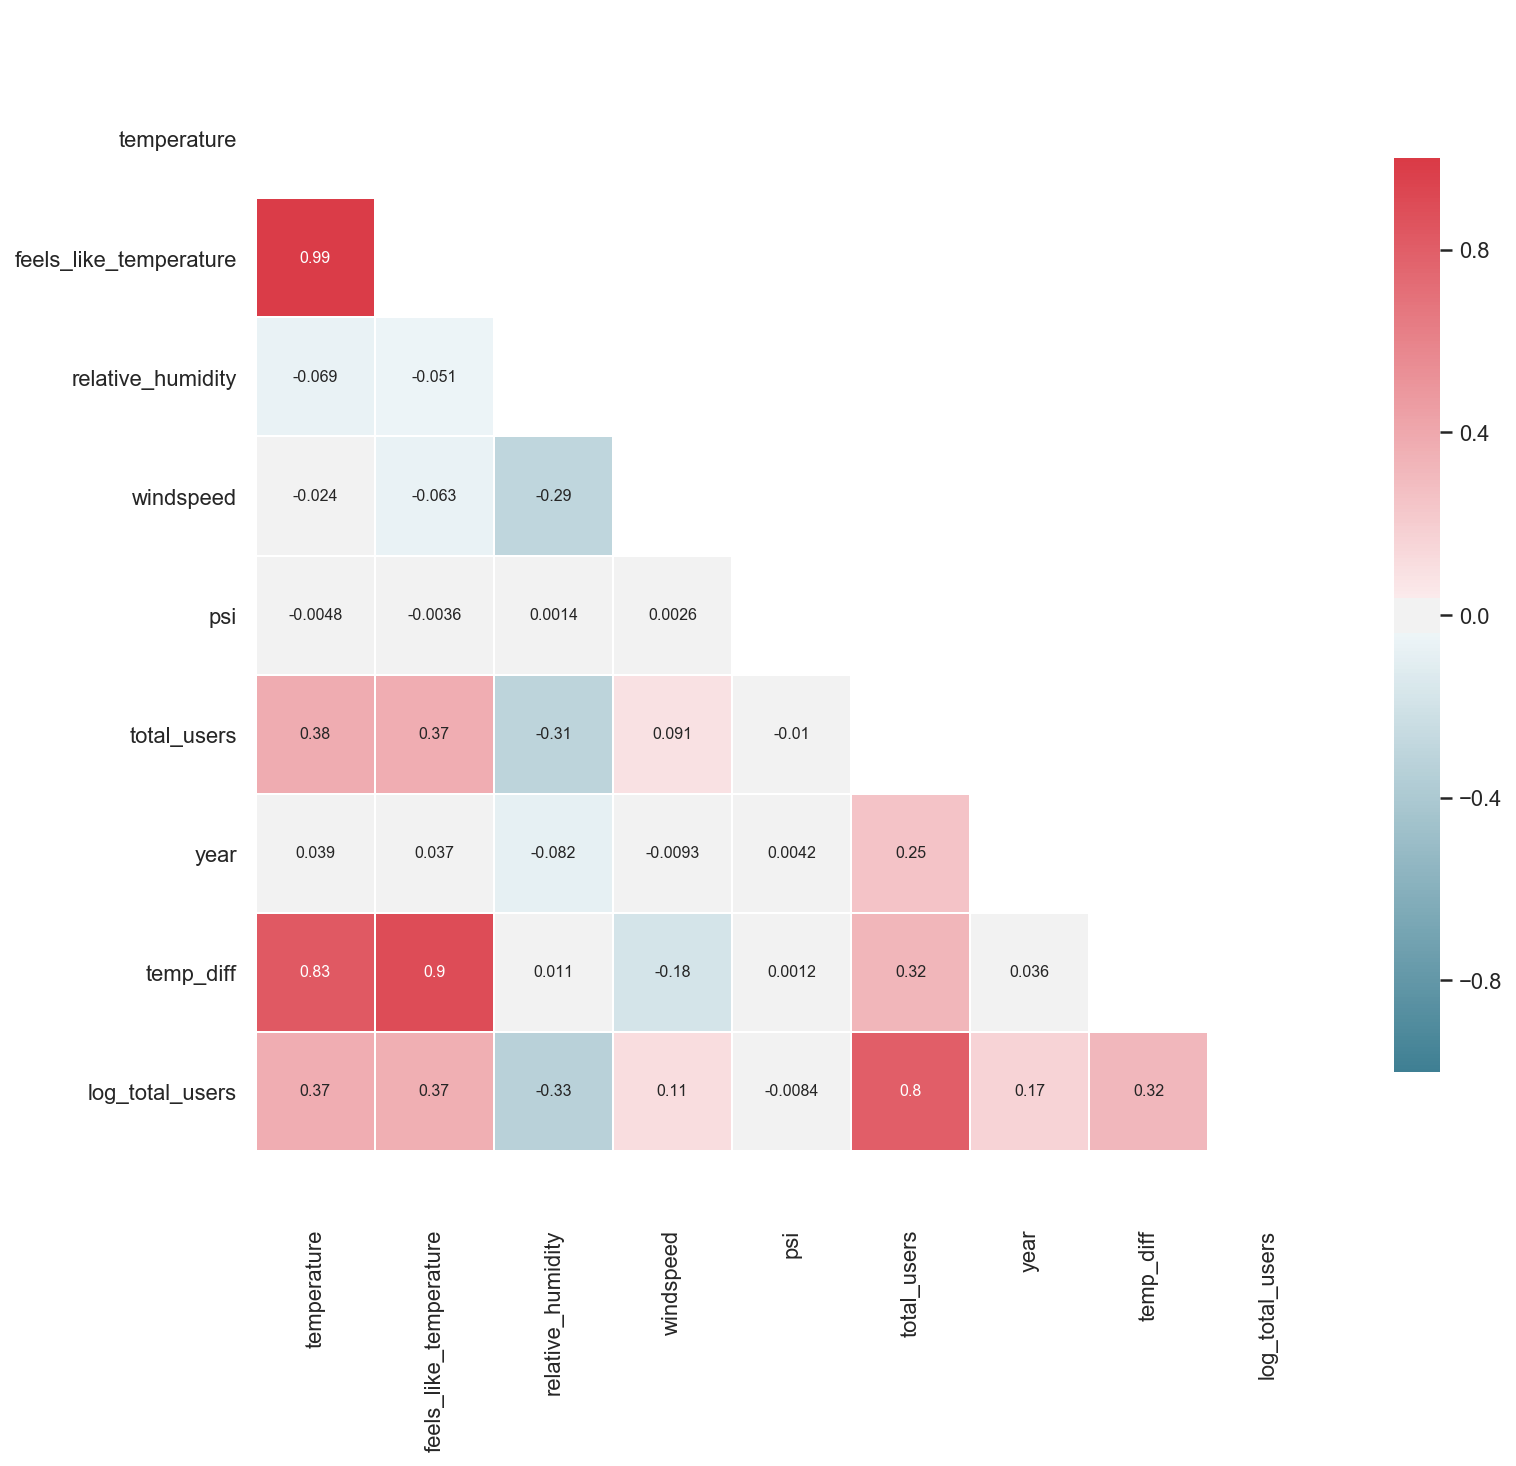

In [13]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7}, annot=True, annot_kws={"size": 8})

bottom, top = ax.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

#### Feature : Temperature and Feels Like Temperature

As highlighted in our earlier plots, we observe that there is a positive releationship between the temperature and the number of users, although the number of users start to decrease at the extreme end of high temperatures.

In [14]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'temperature', 'total_users')

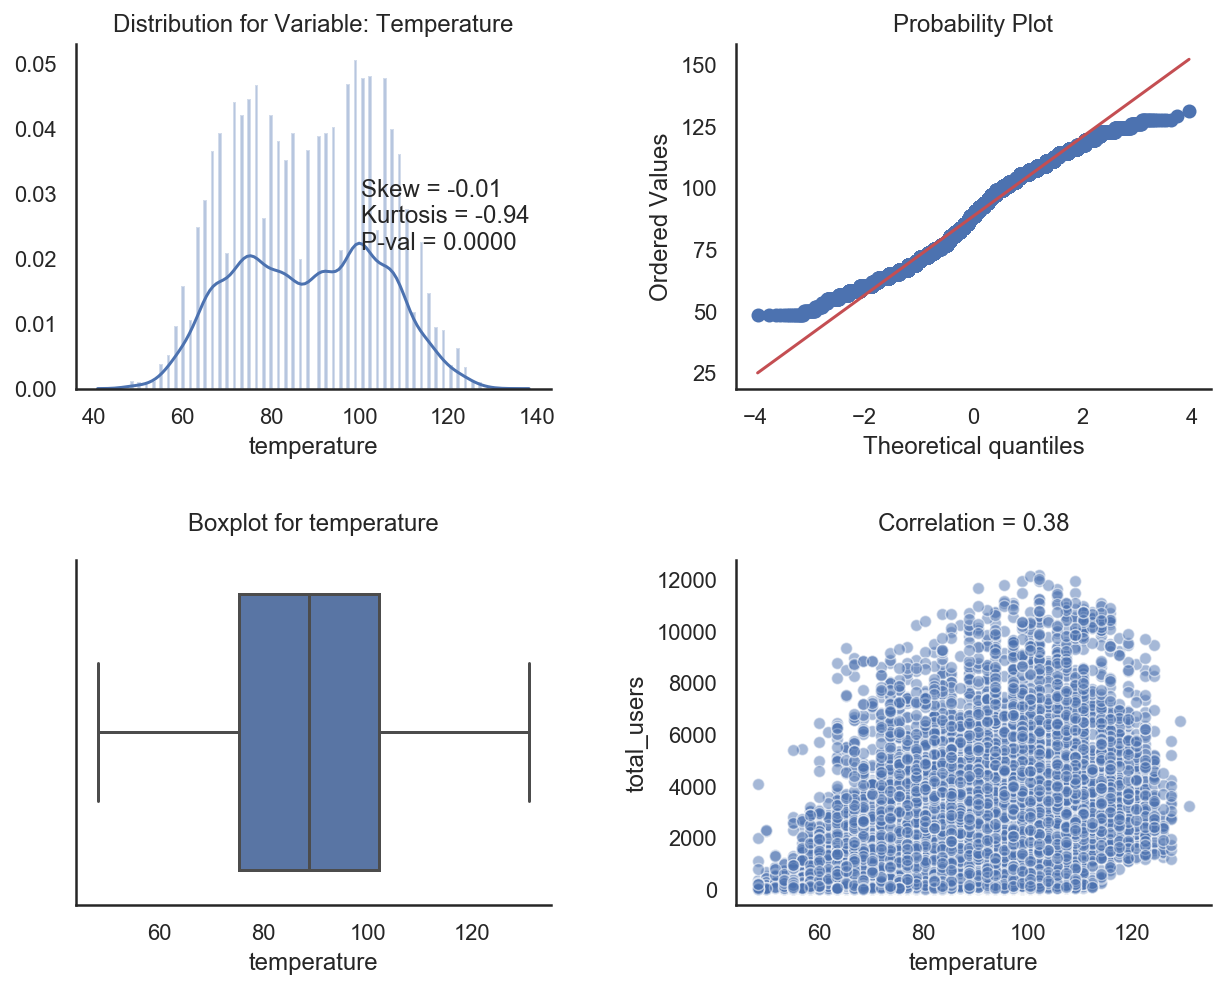

In [15]:
viz.numeric_var_plots(df, 'temperature', 'total_users')

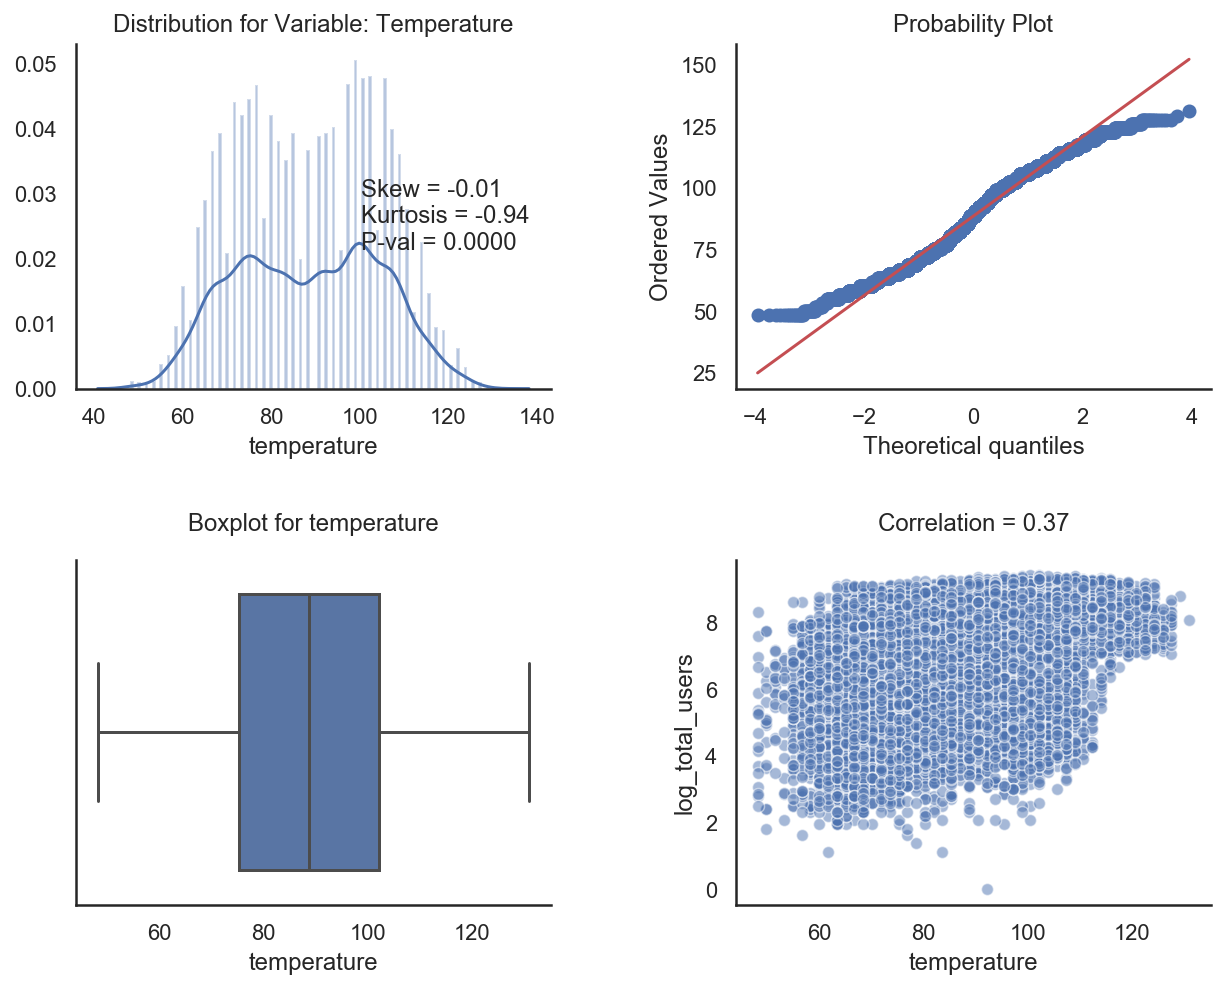

In [16]:
viz.numeric_var_plots(df, 'temperature', 'log_total_users')

In [17]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'feels_like_temperature', 'total_users')

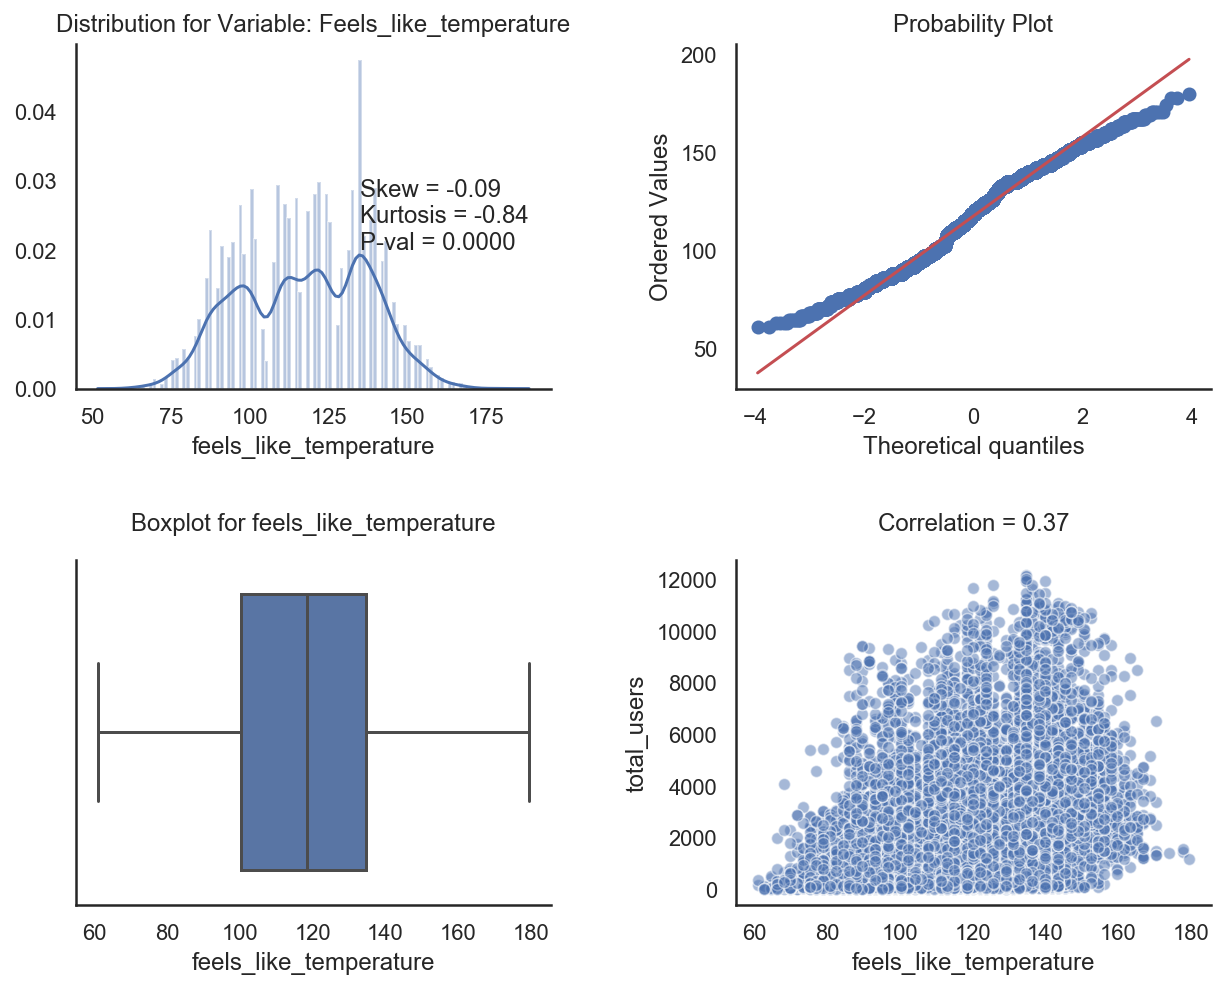

In [18]:
viz.numeric_var_plots(df, 'feels_like_temperature', 'total_users')

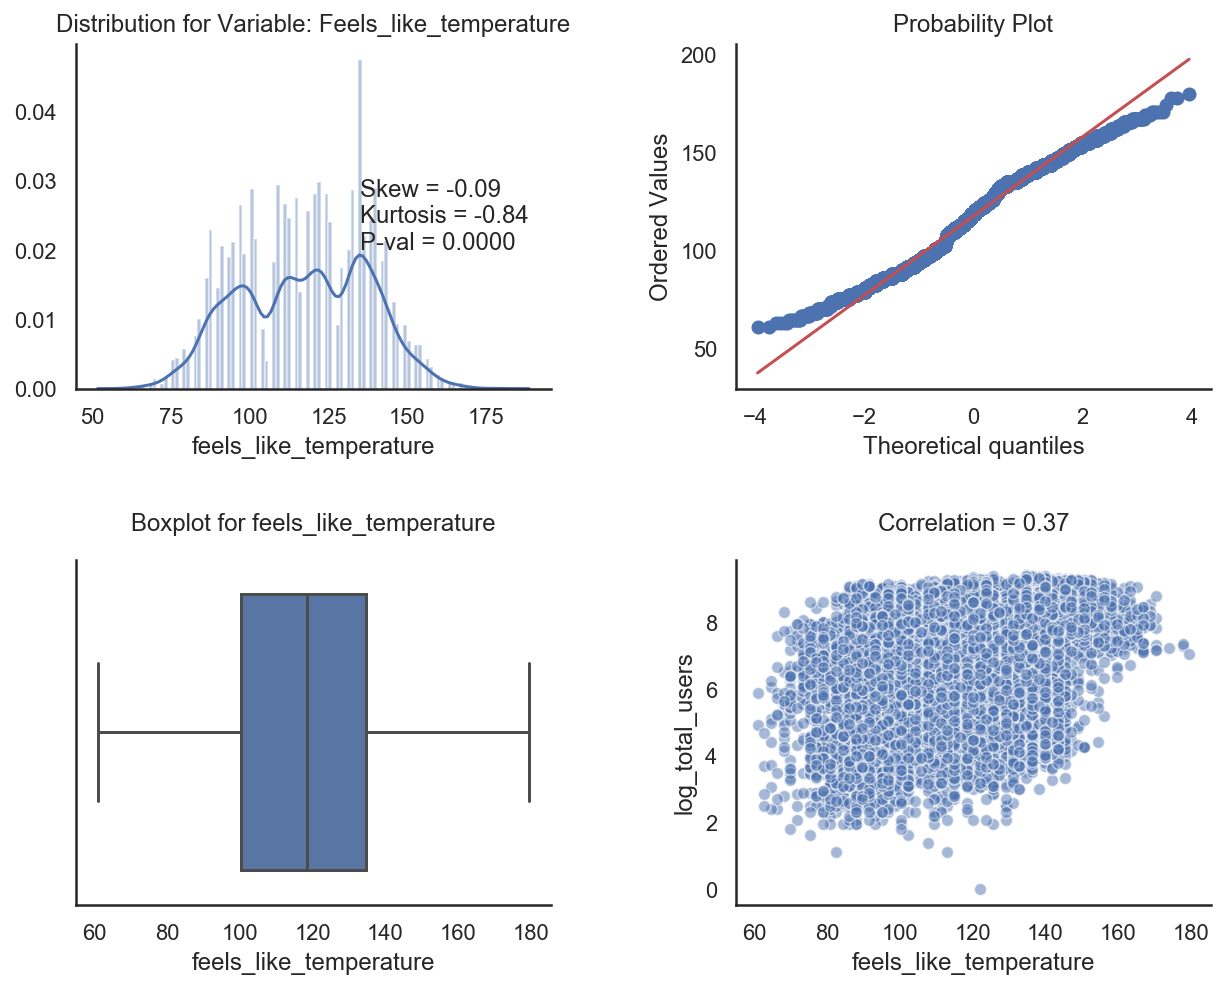

In [19]:
viz.numeric_var_plots(df, 'feels_like_temperature', 'log_total_users')

#### Feature : Windspeed

There seems to be a very weak relationship between windspeed and the total number of users.

In [20]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'windspeed', 'total_users')

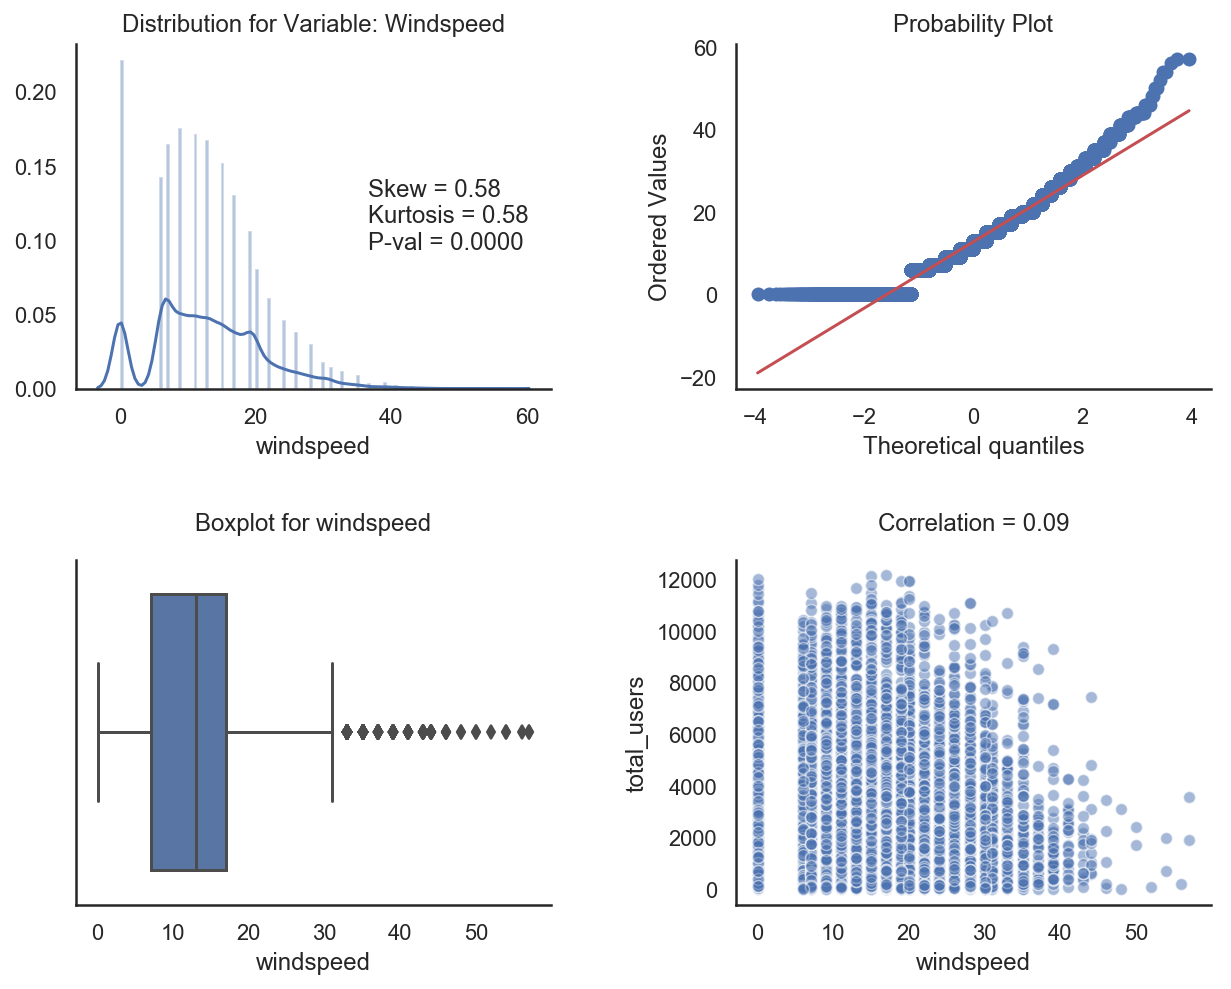

In [21]:
viz.numeric_var_plots(df, 'windspeed', 'total_users')

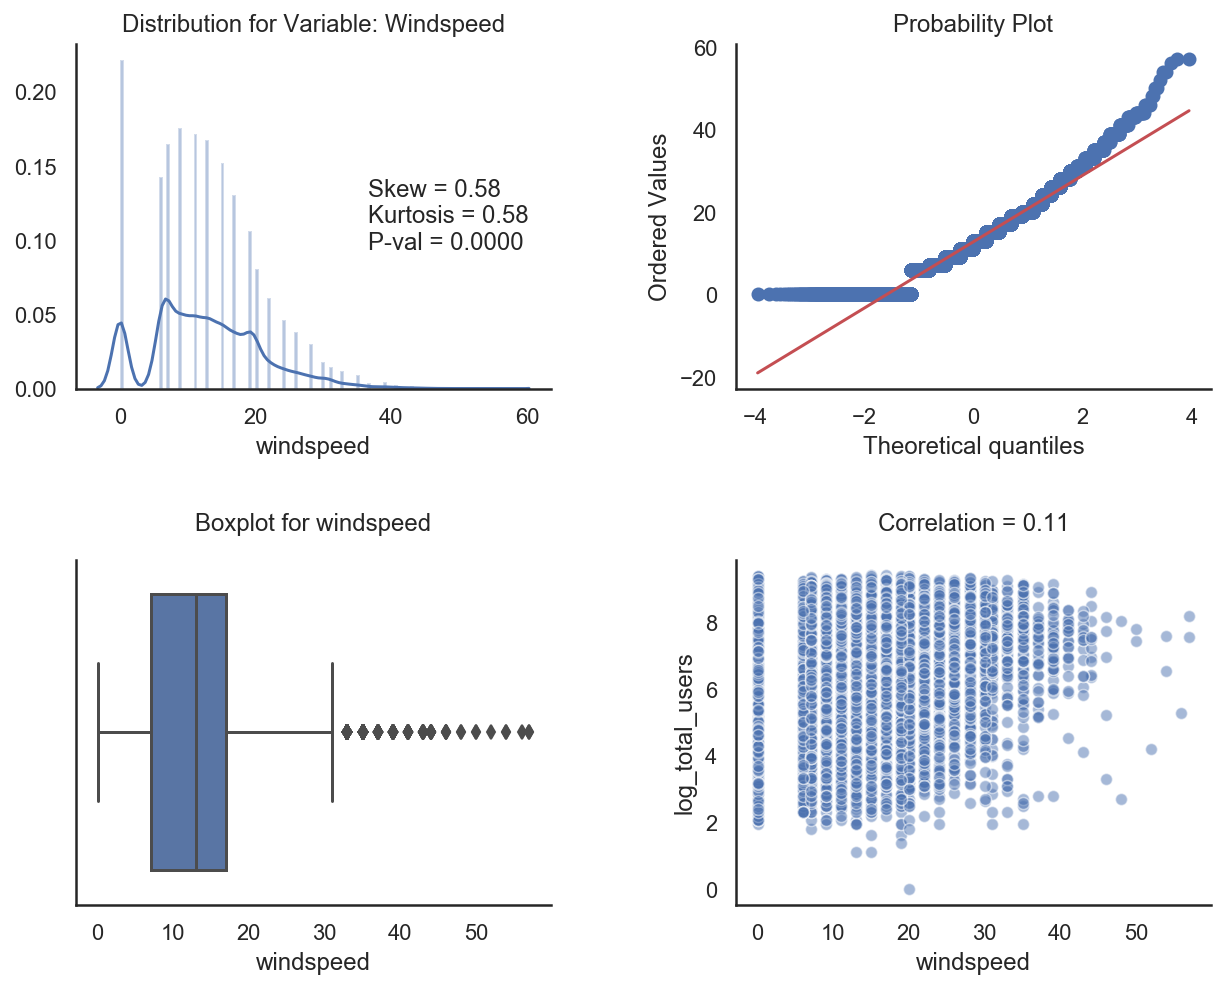

In [22]:
viz.numeric_var_plots(df, 'windspeed', 'log_total_users')

#### Relative Humidity

There appears to be a negative relationship between the relative humidity and the number of users. 

In [23]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'relative_humidity', 'total_users')

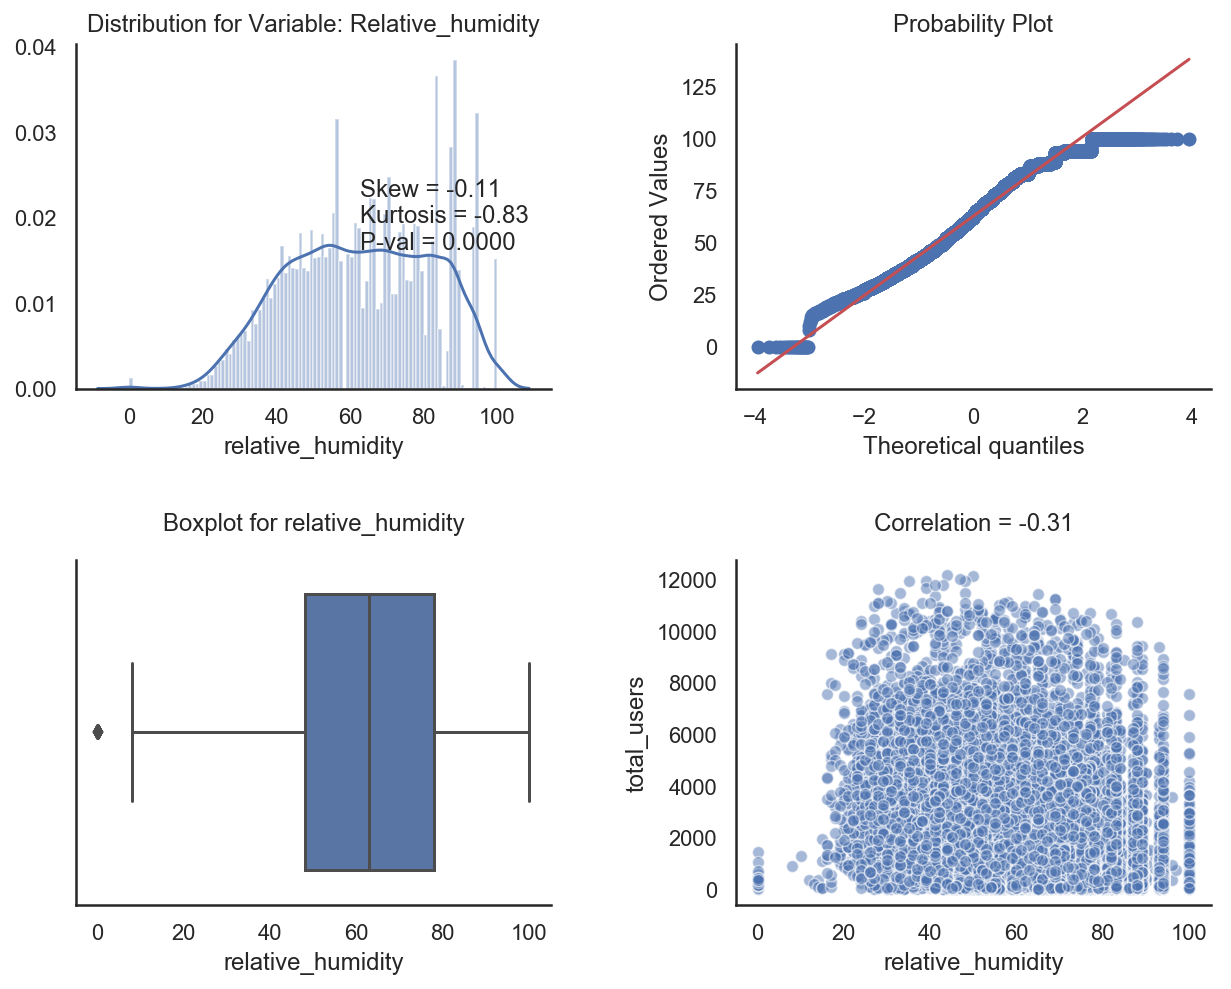

In [24]:
viz.numeric_var_plots(df, 'relative_humidity', 'total_users')

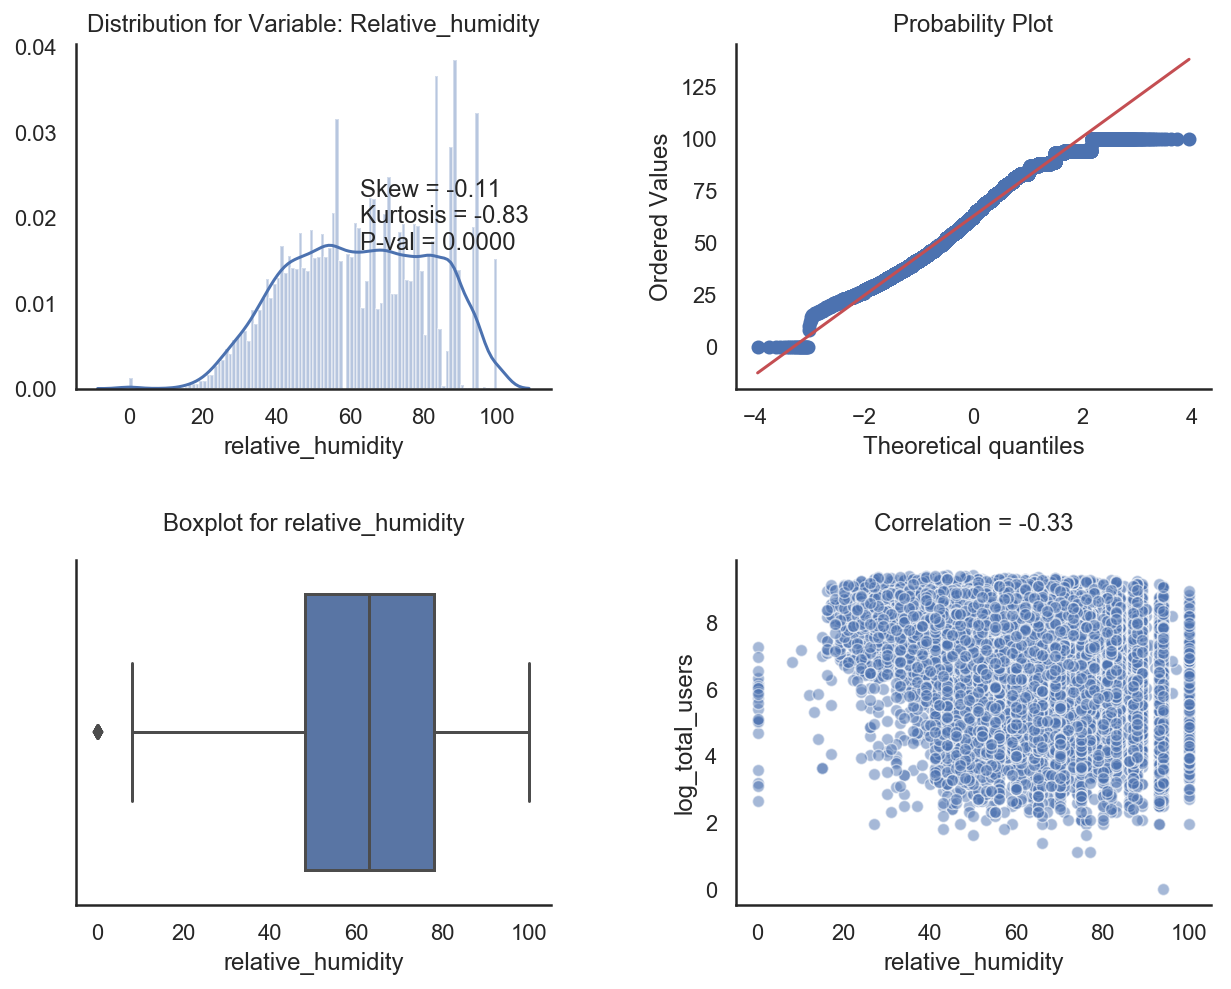

In [25]:
viz.numeric_var_plots(df, 'relative_humidity', 'log_total_users')

#### Feature : Temperarture difference between actual and feels like temperature

In [26]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'temp_diff', 'total_users')

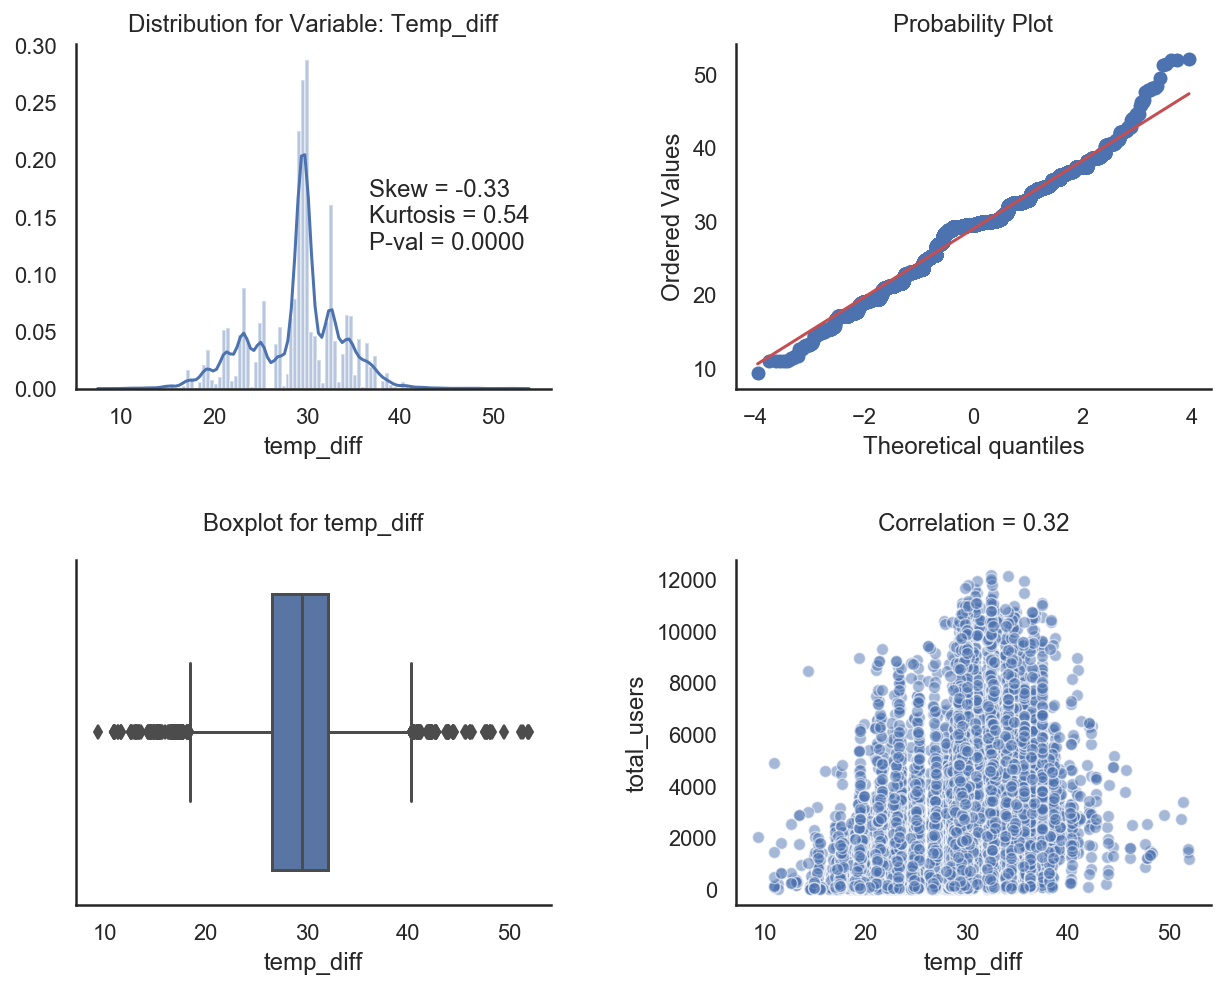

In [27]:
viz.numeric_var_plots(df, 'temp_diff', 'total_users')

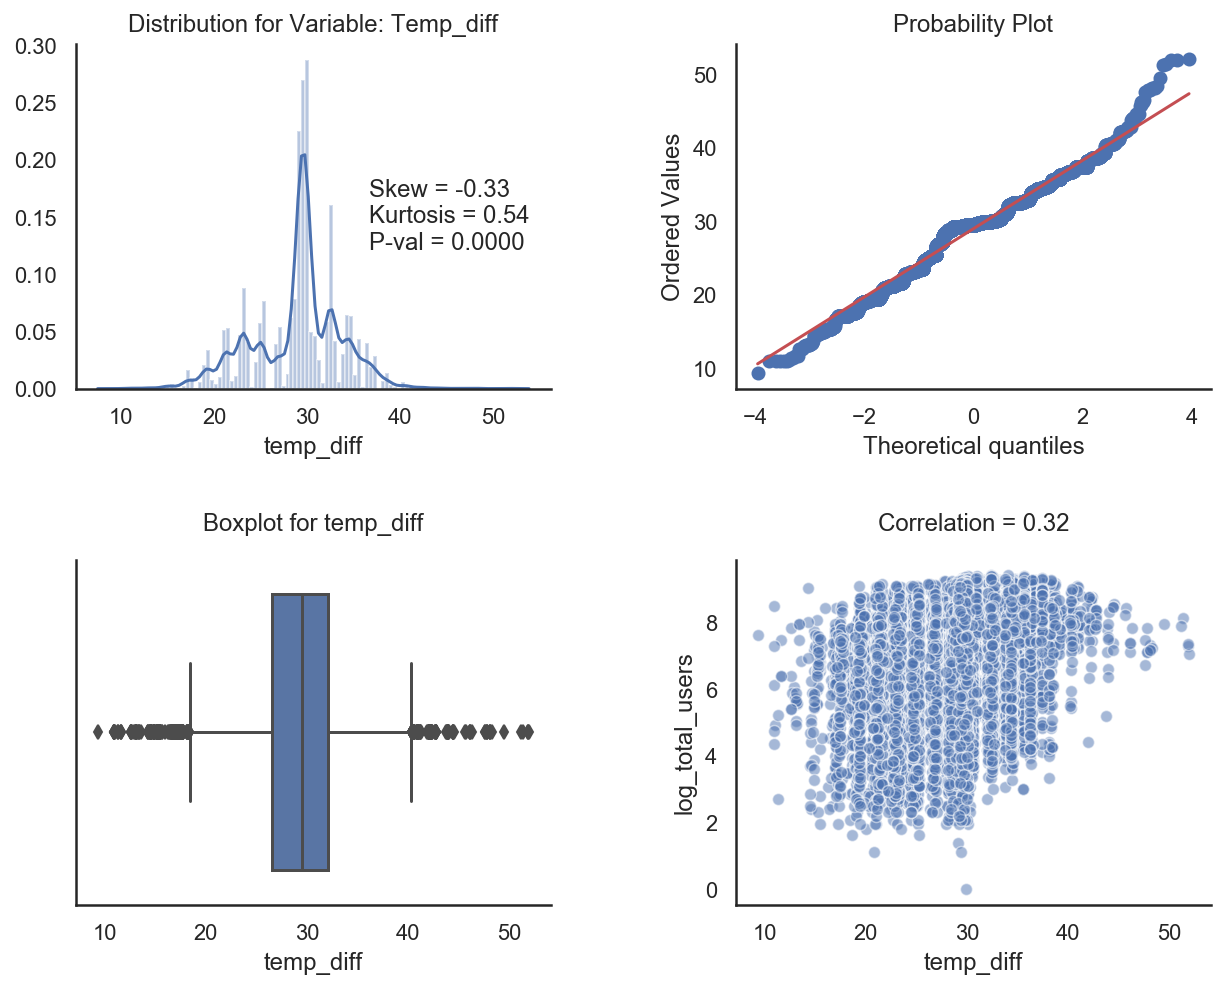

In [28]:
viz.numeric_var_plots(df, 'temp_diff', 'log_total_users')

#### Feature : Psi
There does not appear to be any relationship with the number of users.

In [29]:
# Interactive Scatter Plot - Commented our for to better viewing of notebook
# viz.scatter_plot(df, 'psi', 'total_users')

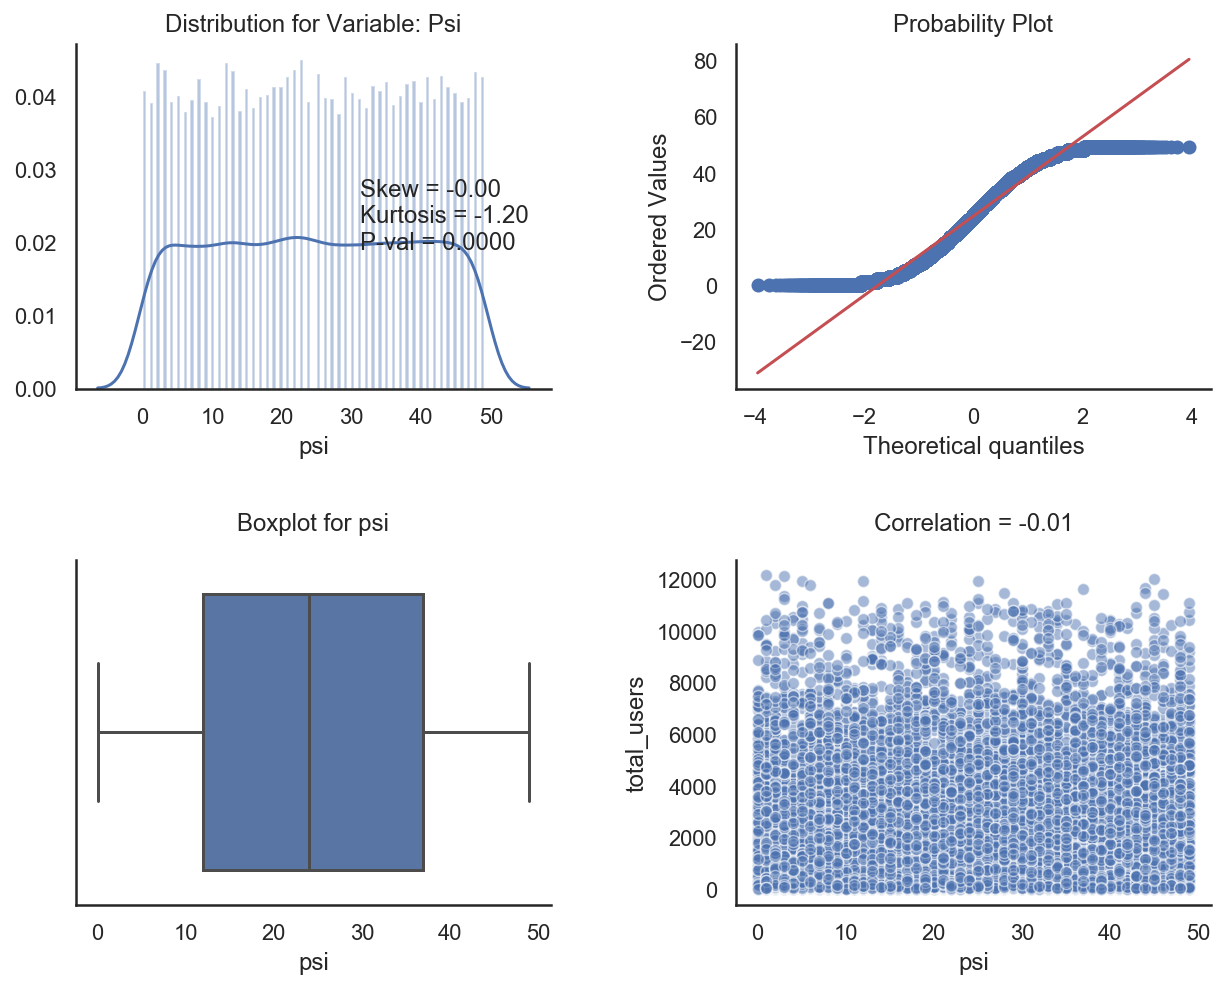

In [30]:
viz.numeric_var_plots(df, 'psi', 'total_users')